# GANITE

__Reference__: [Jinsung Yoon, James Jordon, Mihaela van der Schaar, GANITE: Estimation of Individualized Treatment Effects using Generative Adversarial Nets, ICLR 2018](https://openreview.net/pdf?id=ByKWUeWA-)

__Implementation remarks__: our implementation is exactly the same of the original paper. 

## GANITE on IHDP 

In [1]:
from causalforge.model import Model , PROBLEM_TYPE
from causalforge.data_loader import DataLoader 

# load IHDP dataset 
r = DataLoader.get_loader('IHDP').load()
X_tr, T_tr, YF_tr, YCF_tr, mu_0_tr, mu_1_tr, X_te, T_te, YF_te, YCF_te, mu_0_te, mu_1_te = r

# model 
params={}
params['dim_hidden'] = 100 
params['minibatch_size'] = 256 
params['alpha'] = 0.1
params['beta'] = 0
params['num_iterations'] = 500 
params['num_discr_iterations'] = 1
    
    
ganite = Model.create_model("ganite",
                            params,
                            problem_type=PROBLEM_TYPE.CAUSAL_TREATMENT_EFFECT_ESTIMATION, 
                            multiple_treatments=False)

2023-05-16 14:53:54.629305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from causalforge.metrics import eps_ATE_diff, PEHE_with_ite
import numpy as np

experiment_ids = [1,10,400]

eps_ATE_tr, eps_ATE_te = [], []
eps_PEHE_tr, eps_PEHE_te = [] , [] 



for idx in experiment_ids:    
    t_tr, y_tr, x_tr, mu0tr, mu1tr = T_tr[:,idx] , YF_tr[:,idx], X_tr[:,:,idx], mu_0_tr[:,idx], mu_1_tr[:,idx] 
    t_te, y_te, x_te, mu0te, mu1te = T_te[:,idx] , YF_te[:,idx], X_te[:,:,idx], mu_0_te[:,idx], mu_1_te[:,idx]  
    
    
    # Train your causal method on train-set ...
    ganite.fit(x_tr,t_tr,y_tr)

    # Validate your method test-set ... 
    ATE_truth_tr = (mu1tr - mu0tr).mean()
    ATE_truth_te = (mu1te - mu0te).mean()
    
    ITE_truth_tr = (mu1tr - mu0tr)
    ITE_truth_te = (mu1te - mu0te)
    
    eps_ATE_tr.append( eps_ATE_diff( ganite.predict_ate(x_tr,t_tr,y_tr), ATE_truth_tr) )
    eps_ATE_te.append( eps_ATE_diff( ganite.predict_ate(x_te,t_te,y_te), ATE_truth_te) )
    
    eps_PEHE_tr.append( PEHE_with_ite( ganite.predict_ite(x_tr), ITE_truth_tr, sqrt=True))
    eps_PEHE_te.append( PEHE_with_ite( ganite.predict_ite(x_te), ITE_truth_te , sqrt=True))
        

Generator loss epoch 0: 0.6381762623786926 30.862741470336914
Generator loss epoch 100: 0.003728393232449889 16.405466079711914
Generator loss epoch 200: 0.0014365405077114701 9.917235374450684
Generator loss epoch 300: 0.0011493910569697618 6.902956008911133
Generator loss epoch 400: 0.0013534935424104333 3.959357738494873
Inference loss epoch 0: 21.016639709472656
Inference loss epoch 100: 15.584854125976562
Inference loss epoch 200: 9.773422241210938
Inference loss epoch 300: 8.935896873474121
Inference loss epoch 400: 7.52246618270874
Generator loss epoch 0: 0.6245900392532349 40.30231857299805
Generator loss epoch 100: 0.005318560171872377 22.773630142211914
Generator loss epoch 200: 0.0017221181187778711 14.723432540893555
Generator loss epoch 300: 0.001508277957327664 8.983695983886719
Generator loss epoch 400: 0.0011473450576886535 5.9448418617248535
Inference loss epoch 0: 23.86356544494629
Inference loss epoch 100: 15.311829566955566
Inference loss epoch 200: 13.4427251815795

## Results 

In [3]:
import pandas as pd 

pd.DataFrame([[np.mean(eps_ATE_tr),np.mean(eps_ATE_te),np.mean(eps_PEHE_tr),np.mean(eps_PEHE_te)]],
             columns=['eps_ATE_tr','eps_ATE_te','eps_PEHE_tr','eps_PEHE_te'], 
             index=['DragonNet'])

,eps_ATE_tr,eps_ATE_te,eps_PEHE_tr,eps_PEHE_te
DragonNet,1.289279,1.360971,3.802482,3.843936


## ITE distribution: learned vs. ground truth 

### Learned 

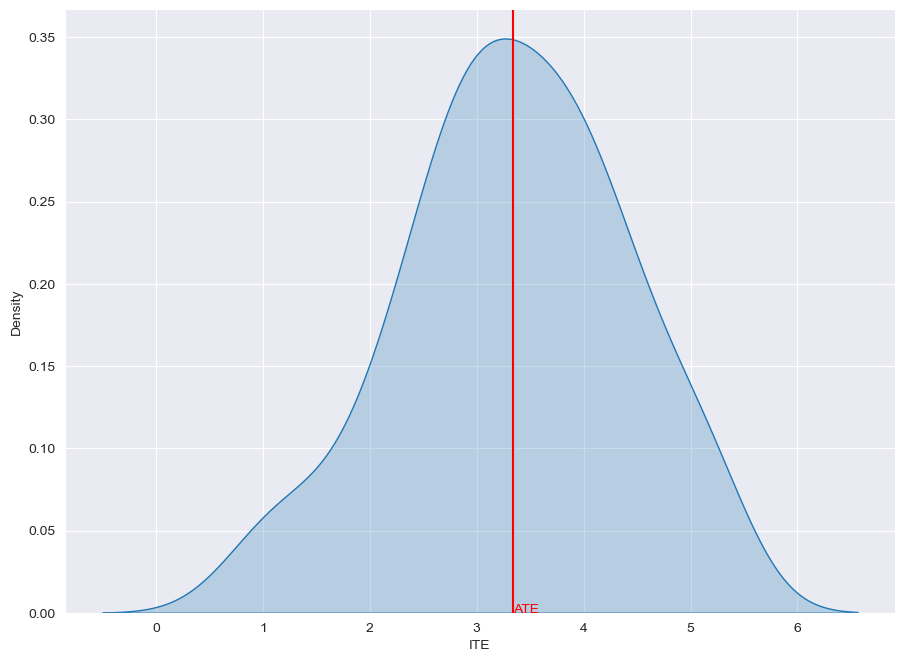

In [4]:
from causalforge.utils import plot_ite_distribution

plot_ite_distribution(ganite.predict_ite(x_te))

### Ground Truth 

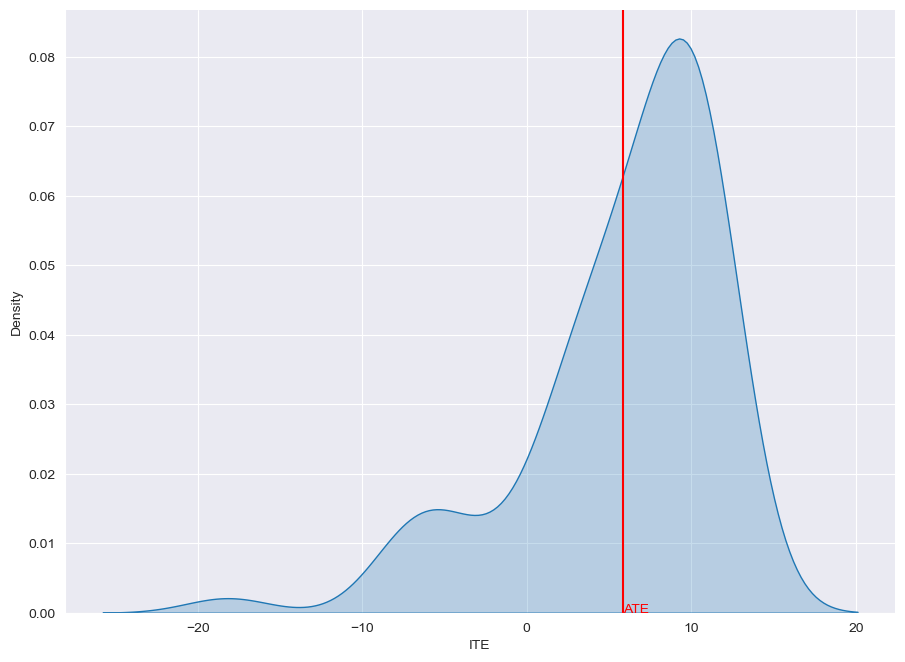

In [5]:
from causalforge.utils import plot_ite_distribution

plot_ite_distribution(ITE_truth_te)